<a href="https://colab.research.google.com/github/dhrits/mec2-projects/blob/main/DSagar_Student_MLE_MiniProject_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project: Build a Machine Learning Model

## Predict Total Fare on the NYC Taxi Dataset

Welcome to the NYC Taxi Fare Prediction project! In this Colab, we will continue using the NYC Taxi Dataset to predict the fare amount for taxi rides using a subset of available features. We will go through three main stages: building a baseline model, creating a full model, and performing hyperparameter tuning to enhance our predictions.

Now that you've completed exploratory data analysis on this dataset you should have a good understanding of the feature space.

## Project Objectives

The primary objectives of this project are as follows:

Baseline Model: We will start by building a simple baseline model to establish a benchmark for our predictions. This model will serve as a starting point to compare the performance of our subsequent models.

Full Model: Next, we will develop a more comprehensive model that leverages machine learning techniques to improve prediction accuracy. We will use Scikit-Learn's model pipeline to build a framework that enables rapid experimentation.

Hyperparameter Tuning: Lastly, we will optimize our full model by fine-tuning its hyperparameters. By systematically adjusting the parameters that control model behavior, we aim to achieve the best possible performance for our prediction task.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Load the NYC taxi dataset into a Pandas DataFrame and do a few basic checks to ensure the data is loaded properly. Note, there are several months of data that can be used. For simplicity, use the Yellow Taxi 2022-01 parquet file [here](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet). Here are your tasks:

  1. Load the `yellow_tripdata_2022-01.parquet` file into Pandas.
  2. Print the first 5 rows of data.
  3. Drop any rows of data that contain NULL values.
  4. Create a new feature, 'trip_duration' that captures the duration of the trip in minutes.
  5. Create a varible named 'target_variable' to store the name of the thing we're trying to predict, 'total_amount'.
  6. Create a list called 'feature_cols' containing the feature names that we'll be using to predict our target variable. The list should contain 'VendorID', 'trip_distance', 'payment_type', 'PULocationID', 'DOLocationID', and 'trip_duration'.

In [38]:
# Load the dataset into a pandas DataFrame (from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
data = pd.read_parquet(' https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet ')

In [39]:
# Display the first few rows of the dataset
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [40]:
# Drop rows with missing values.
data.dropna(inplace=True)

In [41]:
# Confirm dropped NaNs
data.isna().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge     False
airport_fee              False
dtype: bool

In [42]:
# Create new feature, 'trip_duration'.
# Additionally localize to US/Eastern time and then convert to UTC
# to avoid any DST impacts
data['trip_duration'] = (data['tpep_dropoff_datetime'].dt.tz_localize('US/Eastern').dt.tz_convert('UTC') -
                         data['tpep_pickup_datetime'].dt.tz_localize('US/Eastern').dt.tz_convert('UTC'))

In [43]:
data['trip_duration'] = data['trip_duration'].dt.total_seconds()/float(60)

In [44]:
target_variable = 'total_amount'

In [45]:
# Create a list called feature_col to store column names
feature_cols = ['VendorID', 'trip_distance', 'payment_type', 'PULocationID', 'DOLocationID', 'trip_duration']

In [46]:
X = data[feature_cols]
y = data[target_variable]

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2392428 entries, 0 to 2392427
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   VendorID       int64  
 1   trip_distance  float64
 2   payment_type   int64  
 3   PULocationID   int64  
 4   DOLocationID   int64  
 5   trip_duration  float64
dtypes: float64(2), int64(4)
memory usage: 127.8 MB


Splitting a dataset into training and test sets is a crucial step in machine learning model development. It allows us to evaluate the performance and generalization ability of our models accurately. The training set is used to train the model, while the test set serves as an independent sample for evaluating its performance.

1. **Model Training**: The training set is used to fit the model, allowing it to learn the underlying patterns and relationships between the features and the target variable. By exposing the model to a diverse range of examples in the training set, it can capture the underlying structure of the data.

2. **Model Evaluation**: The test set, which is independent of the training set, is crucial for evaluating how well the trained model generalizes to unseen data. It provides an unbiased assessment of the model's performance on new instances. By measuring the model's accuracy, precision, recall, or other evaluation metrics on the test set, we can estimate how well the model will perform on unseen data.

3. **Preventing Overfitting**: Overfitting occurs when a model learns the training data's noise and idiosyncrasies instead of the underlying patterns. By evaluating the model on the test set, we can identify if the model is overfitting. If the model performs significantly worse on the test set compared to the training set, it indicates overfitting. In such cases, we might need to adjust the model, feature selection, or regularization techniques to improve generalization.

4. **Hyperparameter Tuning**: Splitting the dataset allows us to perform hyperparameter tuning on the model. Hyperparameters are configuration settings that control the learning process, such as learning rate, regularization strength, or the number of hidden layers in a neural network. By using a validation set (often created from a portion of the training set), we can iteratively adjust the hyperparameters and select the best combination that maximizes the model's performance on the validation set. The final evaluation on the test set provides an unbiased estimate of the model's performance.

By splitting the dataset into training and test sets, we can ensure that our models are both well-trained and accurately evaluated. This separation helps us understand how the model will perform on new, unseen data, which is critical for assessing its effectiveness and making informed decisions about its deployment.

Here is your task:

  1. Use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into training and test sets. Don't forget to set the random state.

In [48]:
# Split dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

The importance of a baseline model, even if it uses a simple strategy like always predicting the mean, cannot be understated. Here's why a baseline model is valuable:

1. **Performance Comparison**: A baseline model serves as a reference point for evaluating the performance of more sophisticated models. By establishing a simple yet reasonable baseline, we can determine whether our advanced models offer any significant improvement over this basic approach. It helps us set realistic expectations and gauge the effectiveness of our efforts.

2. **Model Complexity**: A baseline model provides insight into the complexity required to solve the prediction task. If a simple strategy like predicting the median performs reasonably well, it suggests that the problem might not necessitate complex modeling techniques. Conversely, if the baseline model performs poorly, it indicates the presence of more intricate patterns that need to be captured by more sophisticated models.

3. **Minimum Performance Requirement**: A baseline model can establish a minimum performance requirement for a predictive task. If we cannot outperform the baseline, it suggests that our models have failed to capture even the most fundamental relationships within the data. In such cases, we may need to revisit our data preprocessing steps, feature engineering techniques, or consider other external factors affecting the task.

4. **Identifying Data Issues**: A baseline model can help identify potential issues within the dataset. If the baseline model performs poorly, it may indicate problems like missing values, outliers, or data inconsistencies. These issues can be further investigated and resolved to improve the overall model performance.

While a baseline model like always predicting the median may not offer the highest prediction accuracy, its importance lies in its role as a starting point for model development and evaluation. It provides a solid foundation for comparing and assessing the performance of more complex models, ensuring that any improvements made are meaningful and significant.

Here is your task:

  1. Create a model that always predicts the mean total fare of the training dataset. Use Scikit-Learn's [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) to evaluate this model. Is it any good?

In [49]:
# Create a baseline for mean absolute error of total amount
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

baseline_reg = DummyRegressor(strategy='mean')
baseline_reg.fit(X_train, y_train)

DummyRegressor()

In [ ]:
from sklearn.model_selection import cross_validate
print(f"MAE on training set: {mean_absolute_error(y_train, baseline_reg.predict(X_train)):.3f}")

MAE on training set: 9.093


In [58]:
print(f"MAE on test set: {mean_absolute_error(y_test, baseline_reg.predict(X_test)):.3f}")

MAE on test set: 9.913


## Note
While this measure of MAE is reliable, it is better to use [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) to get a more reliable estimate of the generalization error. Moving forward, using this instead.

In [60]:
from sklearn.model_selection import cross_validate
results = cross_validate(DummyRegressor(strategy='mean'), X_train, y_train,
                         scoring='neg_mean_absolute_error',
                         return_train_score=True,
                         return_estimator=True)
print(f"cross-validation MAE on training set: {(-(results['test_score'])).mean():.3f} +/- {(-(results['test_score'])).std():.3f}")

cross-validation MAE on training set: 9.093 +/- 0.006


In [61]:
print(f"MAE on test set: {mean_absolute_error(y_test, baseline_reg.predict(X_test)):.3f}")

MAE on test set: 9.913


## Note
In order to evaluate whether the MAE is any good, lets look at the mean and standard deviation of the `total_amount` target field.

In [62]:
print(f'Mean of target variable: {y_train.mean():.3f}')
print(f'Std of target variable: {y_train.std():.3f}')
print(f'Median of target variable: {y_train.median():.3f}')

Mean of target variable: 18.858
Std of target variable: 15.206
Median of target variable: 14.300


## Note
We see that the standard deviation of the target class is quite varied. From this point of view, the MAE seems reasonable **however**, the mean is 19.025 and as such, the error is significant when compared to the magnitude of the mean and median. While it could help in very simple applications, I would not consider this metric good.

With a baseline metric in place, we can try to build a machine learning model. Obviously, if the model can't beat the baseline then there are some major issues to be resolved.

It's always a good idea to start with a simple machine learning model, like linear regression, and build upon it if necessary.

Here are your tasks:

  1. Use Scikit-Learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to preprocess the categorical and continuous features independently. Apply the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to the continuous columns and [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to the categorical columns.

  One-hot encoding is a popular technique used to represent categorical variables numerically in machine learning models. It transforms categorical features into a binary vector representation, where each category is represented by a binary column. Here's an explanation of one-hot encoding:

  When working with categorical variables, such as colors (e.g., red, blue, green) or vehicle types (e.g., car, truck, motorcycle), machine learning algorithms often require numerical inputs. However, directly assigning numerical values to categories can introduce unintended relationships or orderings between them. For example, assigning the values 0, 1, and 2 to the categories red, blue, and green may imply a sequential relationship, which is not desired.

  One-hot encoding solves this problem by creating new binary columns, equal to the number of unique categories in the original feature. Each binary column represents a specific category and takes a value of 1 if the data point belongs to that category, and 0 otherwise. This encoding ensures that no implicit ordering or relationship exists between the categories.

  2. Integrate the preprocessor in the previous step with Scikit-Learn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

  3. Train the pipeline on the training data.

  4. Evaluate the model using mean absolute error as a metric on the test data. Does the model beat the baseline?


In [63]:
# Use Scikit-Learn's ColumnTransformer to preprocess the categorical and
# continuous features independently.

# imports
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

# Note - PULocationID and DOLocationID columns are categorical.
# Based on the instructions in the assignment, they should be
# processed as categorical columns, however, there are a large
# number of categories for each. On low memory instances, it is
# better to treat them as ordinal encodings.

# categorical_columns = ['VendorID', 'payment_type']
# numerical_columns = ['PULocationID', 'DOLocationID', 'trip_distance', 'trip_duration']

# I did this assigmnet using a high RAM instance on Colab
# so I have treated the columns appropriately


categorical_columns = ['PULocationID', 'DOLocationID', 'VendorID', 'payment_type']
numerical_columns = ['trip_distance', 'trip_duration']
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(sparse_output=True, handle_unknown='infrequent_if_exist'),
     categorical_columns),
    remainder='passthrough'
)

In [64]:
# Create a pipeline object containing the column transformations and regression
# model.
clf_pipeline = make_pipeline(
  preprocessor,
  LinearRegression()
)

In [65]:
# Fit the pipeline on the training data.
results_linear = cross_validate(clf_pipeline, X_train, y_train,
                         scoring='neg_mean_absolute_error',
                         return_train_score=True,
                         return_estimator=True)
print(f"cross-validation MAE for linear model on training set: {(-(results_linear['test_score'])).mean():.3f} +/- {(-(results_linear['test_score'])).std():.3f}")

cross-validation MAE for linear model on training set: 3.122 +/- 0.055


In [66]:
# Fit model on all of training data
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['trip_distance',
                                                   'trip_duration']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['PULocationID',
                                                   'DOLocationID', 'VendorID',
                                                   'payment_type'])])),
                ('linearregression', LinearRegression())])

In [67]:
# Make predictions on the test data.
y_train_pred = clf_pipeline.predict(X_train)
y_test_pred = clf_pipeline.predict(X_test)

In [68]:
print(f"MAE on training set: {mean_absolute_error(y_train, y_train_pred):.3f}")
print(f"MAE on test set: {mean_absolute_error(y_test, y_test_pred):.3f}")

MAE on training set: 3.120
MAE on test set: 3.935


## Note
We can see that the LinearRegression classifier performs much better than the baseline.

Random Forest Regression and Linear Regression are two commonly used regression algorithms, each with its own advantages and suitability for different scenarios. Random Forest Regression offers several advantages over Linear Regression, including:

1. **Non-linearity**: Random Forest Regressor is capable of capturing non-linear relationships between features and the target variable. In contrast, Linear Regression assumes a linear relationship between the features and the target. When faced with non-linear relationships or complex feature interactions, Random Forest Regressor can provide more accurate predictions.

2. **Robustness to Outliers**: Random Forest Regressor is generally more robust to outliers compared to Linear Regression. Outliers can disproportionately impact the coefficients and predictions of Linear Regression models. However, as an ensemble of decision trees, Random Forest Regressor can mitigate the effect of outliers by averaging predictions from multiple trees.

3. **Feature Importance**: Random Forest Regressor provides a measure of feature importance, which helps identify the most influential features for making predictions. This information is useful for feature selection, understanding the underlying relationships in the data, and gaining insights into the problem domain. Unlike Linear Regression, which provides coefficient values indicating the direction and magnitude of relationships, Random Forest Regressor explicitly highlights feature importance.

4. **Handling of Categorical Variables**: Random Forest Regressor can effectively handle categorical variables without requiring pre-processing steps like one-hot encoding. It can directly incorporate categorical variables into the model, making it more convenient when working with mixed data types. In contrast, Linear Regression often requires categorical variables to be encoded or transformed before use.

5. **Handling of High-Dimensional Data**: Random Forest Regressor can handle datasets with a large number of features (high dimensionality) by automatically selecting subsets of features during the construction of individual decision trees. This reduces the risk of overfitting, which is a concern with Linear Regression when dealing with high-dimensional data.

6. **Resistance to Multicollinearity**: Random Forest Regressor is less affected by multicollinearity, which occurs when predictor variables are highly correlated. In Linear Regression, highly correlated features can lead to unstable coefficient estimates, making it challenging to interpret the individual effects of each feature. Random Forest Regressor, as an ensemble approach, is less impacted by multicollinearity because each tree is built independently.

Here are your tasks:

  1. Build a Random Forest Regressor model using Scikit-Learn's [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and train it on the train data.

  2. Evaluate the performance of the model on the test data using mean absolute error as a metric. Mess around with various input parameter configurations to see how they affect the model. Can you beat the performance of the linear regression model?

## Note
Given the nature of RandomForestRegressor, we do not need to encode categorical columns using OneHotEncoder. This simlifies the pipeline.

In [69]:
# Deleting pipeline to save memory
# del clf_pipeline

In [75]:
# Build random forest regressor model
from sklearn.ensemble import RandomForestRegressor

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

rf_pipeline = make_pipeline(
  preprocessor,
  RandomForestRegressor(n_estimators=10, max_features='sqrt')
)
results_rf = cross_validate(
    rf_pipeline, X_train, y_train,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True,
    cv=3)

In [76]:
print(f"cross-validation MAE for linear model on training set: {(-(results_rf['test_score'])).mean():.3f} +/- {(-(results_rf['test_score'])).std():.3f}")

cross-validation MAE for linear model on training set: 1.600 +/- 0.010


In [77]:
# Make predictions on the test data
rf_pipeline.fit(X_train, y_train)
y_train_pred_tree = rf_pipeline.predict(X_train)
print(f"MAE on training set: {mean_absolute_error(y_train, y_train_pred_tree):.3f}")

MAE on training set: 0.684


In [78]:
print(f"MAE on test set: {mean_absolute_error(y_test, rf_pipeline.predict(X_test)):.3f}")

MAE on test set: 2.411


## Note
While the RandomForestRegressor **beats the performance of the simple LinearRegression model**, looking at the difference in performance on the train and test set, there is **overfitting to the training set as well**.


## Note
Lets look at the distribution of heights of this random forest

<Axes: ylabel='Count'>

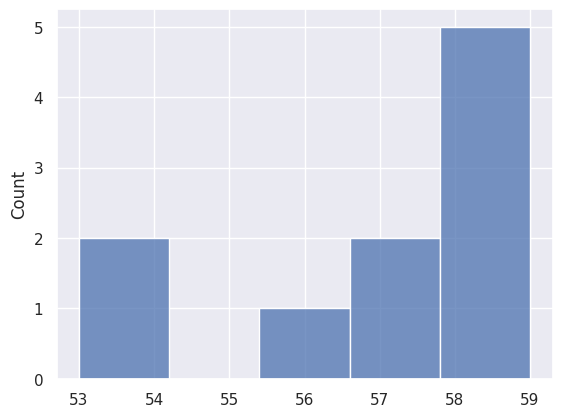

In [79]:
import seaborn as sns
sns.set()

depths = [rf_pipeline.get_params()['randomforestregressor'].estimators_[i].tree_.max_depth for i in range(len(rf_pipeline.get_params()['randomforestregressor'].estimators_))]
sns.histplot(x=depths)

Hyperparameter tuning plays a critical role in machine learning model development. It involves selecting the optimal values for the hyperparameters, which are configuration settings that control the behavior of the learning algorithm. Here's why hyperparameter tuning is so important in ML:

1. **Optimizing Model Performance**: The choice of hyperparameters can significantly impact the model's performance. By fine-tuning the hyperparameters, we can improve the model's accuracy, precision, recall, or other performance metrics. It helps to extract the maximum predictive power from the chosen algorithm and ensures that the model is well-suited to the specific problem at hand.

2. **Avoiding Overfitting and Underfitting**: Hyperparameter tuning helps strike a balance between overfitting and underfitting.

3. **Exploring Model Complexity**: Hyperparameter tuning enables us to explore the complexity of the model. For instance, in algorithms like decision trees or neural networks, we can adjust the number of layers, the number of neurons, or the maximum depth of the tree. By systematically modifying these hyperparameters, we can understand how different levels of complexity impact the model's performance and find the right balance between simplicity and complexity.

Note, there are multiple approaches to hyperparemeter tuning.  

While grid search is the easiest to understand and implement there are many advantages of Bayesian search over grid search for hyperparameter tuning:

1. **Efficiency**: Bayesian search is generally more efficient than grid search. Grid search explores all possible combinations of hyperparameter values, which can be computationally expensive and time-consuming, especially when dealing with a large number of hyperparameters or a wide range of values. Bayesian search, on the other hand, intelligently selects the next hyperparameter configuration to evaluate based on the results of previous evaluations. It focuses on areas of the hyperparameter space that are more likely to yield better performance, reducing the number of evaluations needed.

2. **Flexibility**: Bayesian search is flexible in handling continuous and discrete hyperparameters. It can handle both types of hyperparameters naturally and effectively. In contrast, grid search is more suitable for discrete hyperparameters but may struggle with continuous ones, as it requires discretization or defining a finite set of values to search over.

3. **Adaptive Search**: Bayesian search adapts its search strategy based on the results of previous evaluations. It maintains a probability distribution over the hyperparameter space, updating it with each evaluation. This allows it to dynamically allocate more evaluations to promising regions and explore unexplored areas. In contrast, grid search follows a fixed and predefined search grid, regardless of the results of previous evaluations.

4. **Better Convergence**: Bayesian search has the potential to converge to the optimal hyperparameter configuration more quickly.

Here are your tasks:

  1. Perform a grid-search on a Random Forest Regressor model. Only search the space for the parameters 'n_estimators', 'max_depth', and 'min_samples_split'. Note, this can take some time to run. Make sure you set reasonable boundaries for the search space. Use Scikit-Learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method.

  2. After you've identified the best parameters, train a random forest regression model using these parameters on the full training data.

  3. Evaluate the model from the previous step using the test data. How does your model perform?

In [ ]:
# Define the hyperparameters to tune.
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [None, 20], # Based on the distribution of tree depths. None will grow the tree completely and 20 is 1/3 the height
    'min_samples_split': [2, 0.01]
}
clf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                   return_train_score=True, cv=3, scoring='neg_mean_absolute_error')
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)
pipeline = make_pipeline(
  preprocessor,
  clf,
)

In [ ]:
# Perform grid search to find the best hyperparameters. This could take a while.
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['trip_distance',
                                                   'trip_duration'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=RandomForestRegressor(),
                              param_grid={'max_depth': [None, 20],
                                          'min_samples_split': [2, 0.01],
                                          'n_estimators': [10, 20]},
                              return_train_score=True,
                              scoring='neg_mean_absolute_error'))])

In [ ]:
# Get the best model and its parameters.
pipeline.get_params()['gridsearchcv'].best_estimator_

RandomForestRegressor(max_depth=20, n_estimators=20)

In [ ]:
pipeline.get_params()['gridsearchcv'].best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 20}

In [ ]:
# Fit the best classifier on the training data.
rf = RandomForestRegressor(max_depth=20, min_samples_split=2, n_estimators=20)
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)
pipeline = make_pipeline(
  preprocessor,
  rf,
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=20)

In [ ]:
y_train_pred_rf = rf.predict(X_train)
print(f"MAE on training set: {mean_absolute_error(y_train, y_train_pred_rf):.3f}")

MAE on training set: 1.185


In [ ]:
# Make predictions on the test data
y_test_pred_rf = rf.predict(X_test)
print(f"MAE on test set: {mean_absolute_error(y_test, y_test_pred_rf):.3f}")

MAE on test set: 2.317


## Note
The model selected by GridSearchCV has the best performance on the training and test set thus far.